<h1><center>Fake Audio Detection</center></h1>

## Importing all the necessary libraries

In [1]:
import numpy as np
import pandas as pd 
import os 
import glob
import soundfile as sf
import scipy.io.wavfile
import scipy.signal as signal
import matplotlib.pyplot as plt
import pathlib
import shutil
import random

import tensorflow
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Set Path value to location where AVS_DATA is downloaded

In [2]:
os.getcwd()

Path = 'D:/6th sem subjects/Audio Deepfake Project/' #change '\' to '/' 

os.chdir(Path + 'AVS_Data') #changing current directory to Path/AVS_Data

### Accessing the text file containing information on the audio type and using to it extract real and spoof audio.

In [3]:
data = pd.read_csv('protocol_V2/Audio.txt', sep=" ", header=None)
data.columns = ["File_ID", "Fake_Type", "Speaker_ID", "RedDots", "Env_ID", "Playback_ID", "Recording_ID"]

In [4]:
data.to_csv('AudioData.csv')

In [5]:
data.head()

,File_ID,Fake_Type,Speaker_ID,RedDots,Env_ID,Playback_ID,Recording_ID
0,T_1000001.wav,genuine,M0002,S05,-,-,-
1,T_1000002.wav,genuine,M0002,S09,-,-,-
2,T_1000003.wav,genuine,M0002,S01,-,-,-
3,T_1000004.wav,genuine,M0002,S10,-,-,-
4,T_1000005.wav,genuine,M0002,S04,-,-,-


### Creating a new folder to store real audio files (files termed as bonafide)

In [6]:
data1 = data[data['Fake_Type']== 'genuine']
data1.shape
data1.head()

,File_ID,Fake_Type,Speaker_ID,RedDots,Env_ID,Playback_ID,Recording_ID
0,T_1000001.wav,genuine,M0002,S05,-,-,-
1,T_1000002.wav,genuine,M0002,S09,-,-,-
2,T_1000003.wav,genuine,M0002,S01,-,-,-
3,T_1000004.wav,genuine,M0002,S10,-,-,-
4,T_1000005.wav,genuine,M0002,S04,-,-,-


In [8]:
pathlib.Path(f'AudioData/Real').mkdir(parents=True, exist_ok=True)
realaudio = data1['File_ID']
for file in realaudio:
    file_name = os.path.join('ASVspoof2017_V2_train/',file)
    if os.path.isfile(file_name):
        shutil.copy(file_name, 'AudioData/Real')

### Creating a folder for tts fake audio

In [9]:
data2 = data[data['Fake_Type']=='spoof'] 
data2.shape
data2.head()

,File_ID,Fake_Type,Speaker_ID,RedDots,Env_ID,Playback_ID,Recording_ID
1507,T_1001509.wav,spoof,M0002,S05,E03,P01,R01
1508,T_1001510.wav,spoof,M0002,S09,E21,P02,R01
1509,T_1001511.wav,spoof,M0002,S01,E21,P02,R01
1510,T_1001512.wav,spoof,M0002,S10,E21,P02,R01
1511,T_1001513.wav,spoof,M0002,S04,E21,P02,R01


In [10]:
pathlib.Path(f'AudioData/Spoof_TTS').mkdir(parents=True, exist_ok=True)
ttsaudio = data2['File_ID']
for file in ttsaudio:
    file_name = os.path.join('ASVspoof2017_V2_train/',file)
    if os.path.isfile(file_name):
        shutil.copy(file_name, 'AudioData/Spoof_TTS')

### Creating a folder for VC fake audio

In [10]:
# data3 = data[data['Fake_Type'].isin(['A05','A06','A17','A18', 'A19'])] 
# data3.shape

In [11]:
# pathlib.Path(f'AudioData/Spoof_VC').mkdir(parents=True, exist_ok=True)
# vcaudio = data3['File_ID']
# for file in vcaudio:
#     file_name = os.path.join('flac/',file +'.flac')
#     if os.path.isfile(file_name):
#         shutil.copy(file_name, 'AudioData/Spoof_VC')

## Creating spectogram  and saving the generated images into Image Data folder

### Spectogram of Real Audio data 

In [11]:
pathlib.Path(f'ImageData/Real').mkdir(parents=True, exist_ok=True)
for filename in os.listdir(f'AudioData/Real'):
    y, sr = sf.read(f'AudioData/Real/{filename}')
    print(y)
    plt.specgram(y,Fs=sr)
    plt.axis('off')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    plt.savefig(f'ImageData/Real/{filename}.png')
    plt.clf()

[-0.00085449 -0.00057983 -0.00085449 ...  0.00057983  0.00027466
  0.00115967]
[0.00228882 0.00152588 0.         ... 0.00189209 0.00228882 0.00305176]
[0.00033569 0.0020752  0.00274658 ... 0.00448608 0.00448608 0.00448608]
[ 0.06433105  0.06781006  0.08056641 ... -0.00085449 -0.0017395
 -0.00085449]
[-0.00350952 -0.00195312 -0.00234985 ...  0.00311279  0.00350952
  0.00311279]
[ 0.0887146  -0.00198364  0.07275391 ...  0.00158691  0.00158691
  0.00241089]
[0.00158691 0.00192261 0.00030518 ... 0.00762939 0.00668335 0.00762939]
[-0.13790894 -0.14212036 -0.14559937 ...  0.00454712 -0.0017395
 -0.0017395 ]
[ 0.17816162  0.16842651  0.21478271 ... -0.00064087  0.
  0.00030518]
[ 0.04275513 -0.01779175 -0.02838135 ... -0.00186157 -0.00186157
 -0.00094604]
[ 0.04415894  0.04290771  0.04544067 ... -0.00946045 -0.00881958
 -0.00692749]
[0.0927124  0.09228516 0.08737183 ... 0.02297974 0.02215576 0.02215576]
[-0.07843018 -0.08251953 -0.08178711 ... -0.01531982 -0.00561523
  0.00073242]
[0.06542969

c:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\axes\_axes.py:7720: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


[ 0.          0.          0.         ... -0.00039673 -0.00091553
 -0.0007019 ]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.57763672e-04
 -6.71386719e-04  6.10351562e-05]
[ 0.          0.          0.         ... -0.00137329 -0.00094604
 -0.00109863]
[0.         0.         0.         ... 0.00030518 0.00015259 0.00036621]
[-0.00265503 -0.00213623 -0.00152588 ... -0.00088501 -0.00128174
 -0.00177002]
[-0.00119019 -0.00094604 -0.00067139 ... -0.00064087 -0.00021362
 -0.00033569]
[-0.00131226  0.00018311  0.00177002 ... -0.00463867 -0.00323486
 -0.00332642]
[ 0.0272522   0.00213623  0.03317261 ... -0.0005188  -0.00018311
 -0.00057983]
[-0.00131226  0.00015259  0.00164795 ...  0.00280762  0.00375366
  0.00170898]
[-0.00018311  0.00015259 -0.00030518 ...  0.00134277  0.00140381
  0.00112915]
[ 0.          0.          0.         ... -0.00143433  0.00012207
 -0.00079346]
[ 0.          0.          0.         ...  0.00088501 -0.00222778
  0.00045776]
[ 0.          0.          0.       

<Figure size 640x480 with 0 Axes>

### Spectogram of TTS Fake Audio data 

In [12]:
pathlib.Path(f'ImageData/Spoof_TTS').mkdir(parents=True, exist_ok=True)
for filename in os.listdir(f'AudioData/Spoof_TTS'):
    y, sr = sf.read(f'AudioData/Spoof_TTS/{filename}')
    plt.specgram(y,Fs=sr)
    plt.axis('off')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    plt.savefig(f'ImageData/Spoof_TTS/{filename}.png')
    plt.clf()

<Figure size 640x480 with 0 Axes>

### Copying all Spectograms into one folder (Spectograms)

In [40]:
pathlib.Path(f'Spectograms').mkdir(parents=True, exist_ok=True)
for f in ('Real/', 'Spoof_TTS/'):
    for jpgfile in glob.iglob(os.path.join('ImageData/'+f, "*.png")):
        shutil.copy(jpgfile, 'Spectograms')

# Model Building

## Image Parameters 

In [41]:
# Define Constants
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### Creating a dataframe all the images and assigning them labels accordingly

In [42]:
# Read the real and spoof spectrogram images from directory
filename1 = os.listdir("ImageData/Real/")
filename2 = os.listdir("ImageData/Spoof_TTS/")
# filename3 = os.listdir("ImageData/Spoof_VC/")
category1 = []
category2 = []
# category3 = []

In [43]:
# Check the length of the list
print(len(filename1))
print(len(filename2))
# print(len(filename3))

1507
1507


In [44]:
# Shuffle the data randomly
random.shuffle(filename1)
random.shuffle(filename2)
# random.shuffle(filename3)

In [45]:
# Get filename and assign label '0' for real images and stored in dataframe
for filename in filename1:
    category1.append(0)    
df1 = pd.DataFrame({ 'filename': filename1,'category': category1 })    

# Get filename and assign label '1' for TTS fake images and stored in dataframe
for filename in filename2:
    category2.append(1)    
df2 = pd.DataFrame({ 'filename': filename2, 'category': category2 })

# Get filename and assign label '2' for VC fake images and stored in dataframe
# for filename in filename3:
#     category3.append(2)    
# df3 = pd.DataFrame({ 'filename': filename3, 'category': category3 })

In [46]:
# Combined the dataframes
frames = [df1, df2]
df = pd.concat(frames)

In [47]:
# Dataframe structure
df.head(4)

,filename,category
0,T_1000634.wav.png,0
1,T_1001456.wav.png,0
2,T_1001388.wav.png,0
3,T_1001330.wav.png,0


<AxesSubplot: >

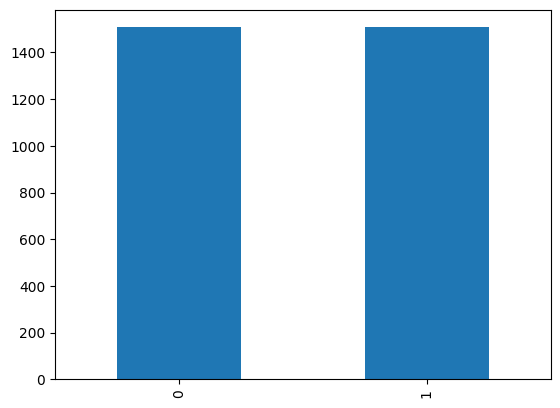

In [48]:
df['category'].value_counts().plot.bar()

## Building the CNN model

In [49]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [50]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 61, 61, 64)      

In [52]:
# To prevent over fitting , stop the learning after 10 epochs and reduce learning rate after two steps
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [53]:
# Saved callbacks parameters
callbacks = [earlystop, learning_rate_reduction]

In [54]:
# Replace output label data
df["category"] = df["category"].replace({0: 'Real', 1: 'TTS_Spoof'}) 

In [55]:
# Data splitting into train and test data and keep this test data aside for model prediction
trainData_df, testData_df = train_test_split(df, test_size=0.20, random_state=42)
trainData_df = trainData_df.reset_index(drop=True)
testData_df = testData_df.reset_index(drop=True)

In [28]:
# Again split the above train data into new train dataset (used to train the model ) 
# and validation set
train_df, validate_df = train_test_split(trainData_df, test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot: >

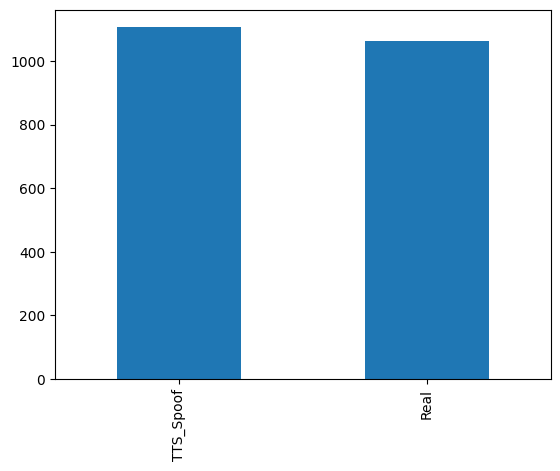

In [56]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot: >

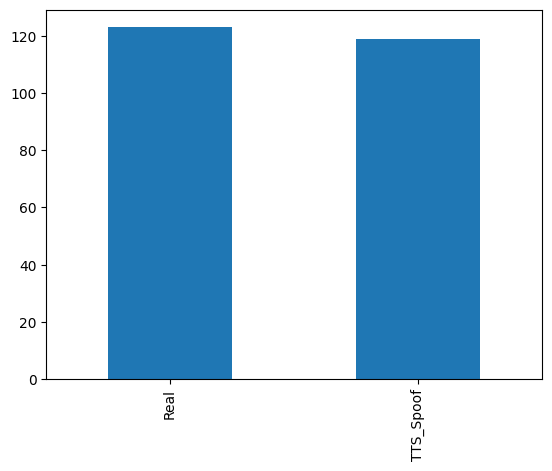

In [60]:
validate_df['category'].value_counts().plot.bar()

In [61]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = testData_df.shape[0]
batch_size=15

In [62]:
# generic image data generator 
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [63]:
# Train image data generator
# Create new train folder directory which should have both the images real and fake combined.
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "Spectograms", 
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2169 validated image filenames belonging to 2 classes.


In [33]:
# # Validation image data generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "Spectograms",
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


c:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 242 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


# Model Fit

In [64]:
epochs=5 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch= 100, #total_train//batch_size, 
    callbacks=callbacks   
)

C:\Users\abhin\AppData\Local\Temp\ipykernel_6576\2971640433.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
100/100 [==============================] - 47s 463ms/step - loss: 0.6412 - accuracy: 0.7992 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 40s 402ms/step - loss: 0.4151 - accuracy: 0.8481 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 38s 383ms/step - loss: 0.3823 - accuracy: 0.8540 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 39s 385ms/step - loss: 0.3371 - accuracy: 0.8715 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 38s 383ms/step - loss: 0.3565 - accuracy: 0.8641 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 38s 375ms/step - loss: 0.3398 - accuracy: 0.8693 - lr: 0.0010
Epoch 7/50
100/100 [==============================] - 38s 375ms/step - loss: 0.3487 - accuracy: 0.8601 - lr: 0.0010
Epoch 8/50
100/100 [==============================] - 38s 374ms/step - loss: 0.3106 - accuracy: 0.8822 - lr: 0.0010
Epoch 9/50
100/100 [==============================] - 37s 374ms/step - l

# Visualization

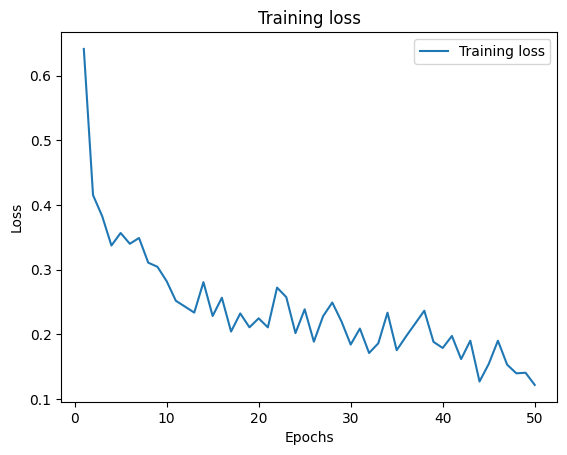

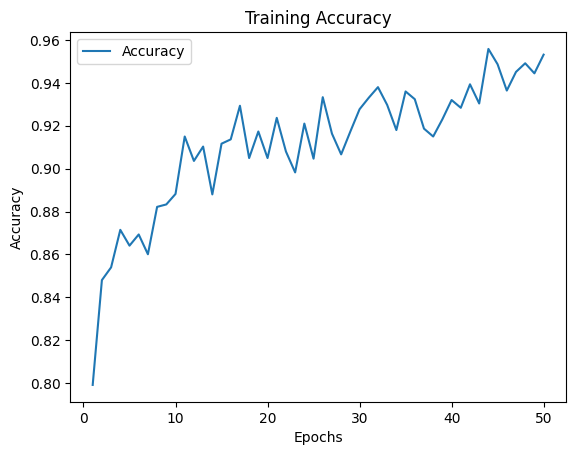

KeyError: 'val_accuracy'

In [67]:
# def visualize(loss, val_loss):
#     '''
#     Plots a graph for training and validation loss and accuracy
#     '''
#     epochs = range(1,len(loss)+1)

#     plt.figure()
#     plt.plot(epochs,loss,'rv',label='Training loss')
#     plt.plot(epochs,val_loss,'g',label='Validation loss')
#     plt.title('Training and Validation loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

def visualize1(loss):
    '''
    Plots a graph for training loss and accuracy
    '''
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs,loss,label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def visualize2(accuracy):
    '''
    Plots a graph for accuracy
    '''
    epochs = range(1,len(accuracy)+1)
    plt.figure()
    plt.plot(epochs,accuracy,label='Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def visualize3(val_accuracy):
    '''
    Plots a graph for val accuracy
    '''
    epochs = range(1,len(val_accuracy)+1)
    plt.figure()
    plt.plot(epochs,val_accuracy,'g', label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Validation accuracy')
    plt.legend()
    plt.show()

# visualize(history.history['loss'], history.history['val_loss'])
visualize1(history.history['loss'])
visualize2(history.history['accuracy'])
visualize3(history.history['val_accuracy'])

In [68]:
# Used above created test dataset for test image data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    testData_df, 
    "Spectograms",
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 603 validated image filenames belonging to 2 classes.


# Model Prediction

In [84]:
predict = model.predict_generator(test_generator, steps=np.ceil(total_test/batch_size), verbose= 1)

C:\Users\abhin\AppData\Local\Temp\ipykernel_6576\3732656847.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(total_test/batch_size), verbose= 1)


41/41 [==============================] - 5s 122ms/step


In [85]:
testData_df['Pred_category'] = np.argmax(predict, axis=1)

In [86]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
testData_df['Pred_category'] = testData_df['Pred_category'].replace(label_map)

<Figure size 640x480 with 0 Axes>

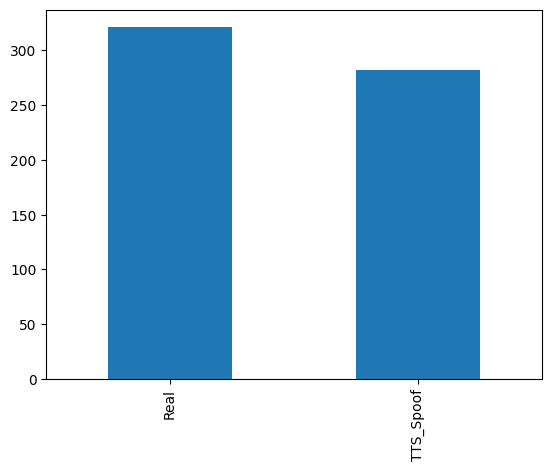

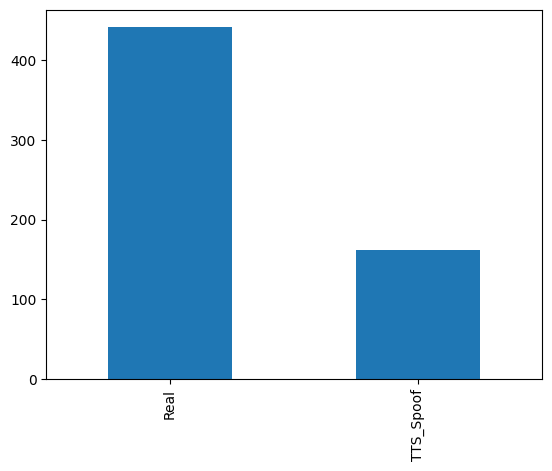

In [87]:
plt.figure()
plt.subplots(1,1)
testData_df['category'].value_counts().plot.bar()
plt.subplots(1,1)
testData_df['Pred_category'].value_counts().plot.bar()
plt.show()

In [88]:
testData_df['category'].value_counts()

Real         321
TTS_Spoof    282
Name: category, dtype: int64

In [89]:
testData_df['Pred_category'].value_counts()

Real         441
TTS_Spoof    162
Name: Pred_category, dtype: int64

In [92]:
print('Prediction Accuracy =',metrics.accuracy_score(testData_df['category'], testData_df['Pred_category']))

Prediction Accuracy = 0.8346984654554932


In [81]:
# import pickle
# with open('model.pickle','wb') as f:
#         pickle.dump(model,f)